In [3]:
import pandas as pd
import numpy as np
import os
os.chdir('../')
print(os.getcwd())

e:\hr-machine-learning


In [4]:
train=pd.read_csv('data/aug_train.csv')
test=pd.read_csv('data/aug_test.csv')

In [5]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [6]:
(train.isnull().sum()*100)/len(train)

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

In [7]:
train.nunique()

enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
target                        2
dtype: int64

# Data preprocessing

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [9]:
# Dropping enrollee_id because it contain no useful information,city because city development index categories cities.
X=train.drop(columns=['enrollee_id','city','target'],axis=1)
y=train['target']

In [10]:
#numerical columns
num=X.select_dtypes(exclude='object').columns

#categorical columns
cat=X.select_dtypes(include='object').columns

In [11]:
impute=SimpleImputer(strategy='most_frequent')

Xc=impute.fit_transform(X[cat])

In [12]:
encoding=OneHotEncoder()

Xc=encoding.fit_transform(Xc)

In [13]:
transform=PowerTransformer()

Xn=transform.fit_transform(X[num])

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Feature Selection

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

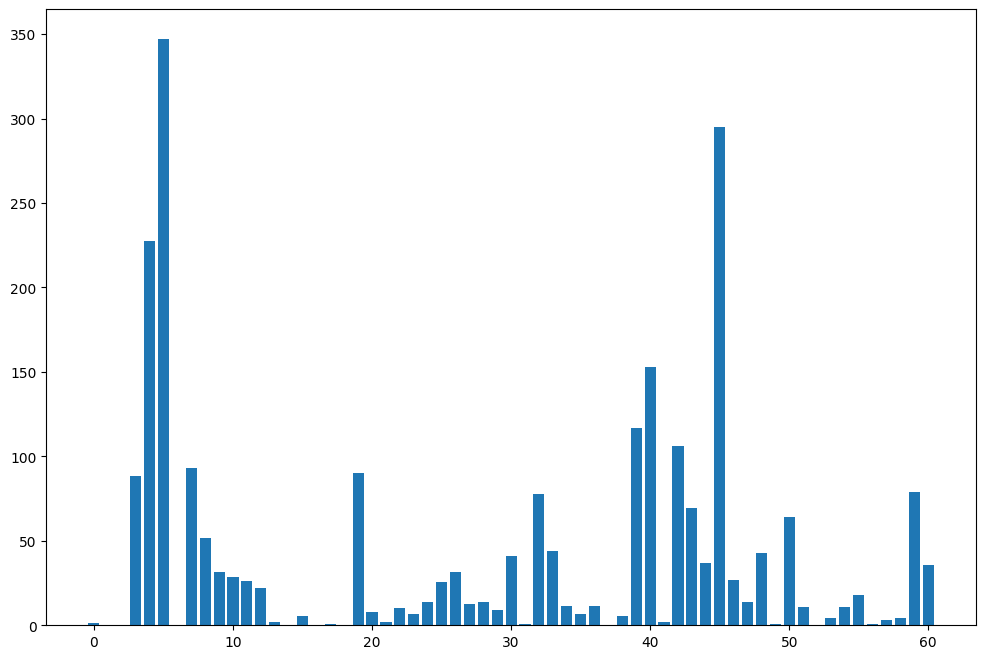

In [16]:
fs=SelectKBest(score_func=chi2,k='all')
fs.fit(Xc,y)
#chi square method is used to test for independence of categorical variables

plt.figure(figsize=(12,8))
plt.bar([i for i in range(len(fs.scores_))],fs.scores_);

In [17]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [18]:
def evaluate(X,y,model):
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    return scores

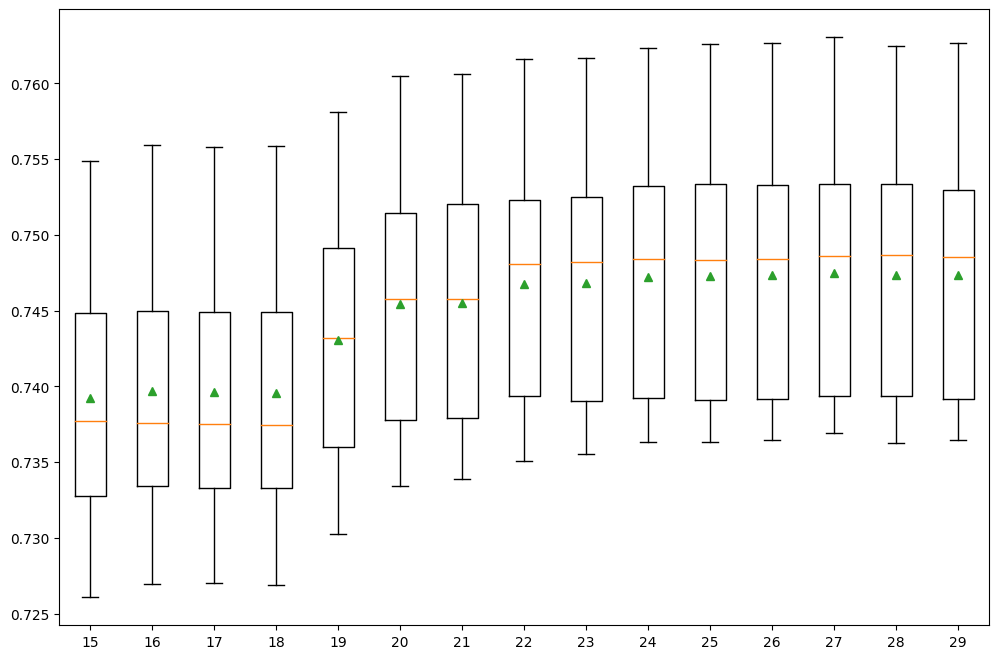

In [19]:
results=[]
Xc=Xc.toarray()

for i in range(15,30):
    fs=SelectKBest(score_func=chi2,k=i)
    fs.fit(Xc,y)
    
    Xfs=fs.transform(Xc)
    X=np.concatenate([Xn,Xfs],axis=1)
    
    results.append(evaluate(X,y,LogisticRegression()))
    
plt.figure(figsize=(12,8))
plt.boxplot(results,labels=range(15,30),showmeans=True);

In [ ]:
# ROC stagnant after 23, hence k=23

In [20]:
fs=SelectKBest(score_func=chi2,k=23)
fs.fit(Xc,y)

Xfs=fs.transform(Xc)
X=np.concatenate([Xn,Xfs],axis=1)

X.shape

(19158, 25)

In [21]:
def get_models():
    
    models=[]
    names=[]
    
    models.append(LogisticRegression())
    names.append('lr') 
                  
    models.append(RandomForestClassifier())
    names.append('rf')              
                  
    models.append(KNeighborsClassifier())
    names.append('knn')
    
    models.append(GaussianNB())
    names.append('nb')
    
    models.append(AdaBoostClassifier())
    names.append('adb')
    
    models.append(GradientBoostingClassifier())
    names.append('grb')

    return models,names

In [22]:
results=[]
model,names=get_models()

for i in range(len(model)):
    results.append(evaluate(X,y,model[i]))
    
for i in range(len(results)):
    print(f'{names[i]}: {results[i].mean()}, {(results[i].std())}')

lr: 0.7468565102327064, 0.008475926531688553
rf: 0.7306484468136459, 0.006223937814615593
knn: 0.7023472471968455, 0.005096517263224064
nb: 0.6842526805026311, 0.0045710174157115886
adb: 0.7819725312026293, 0.007954679538855047
grb: 0.7844708388800492, 0.008043238241257307


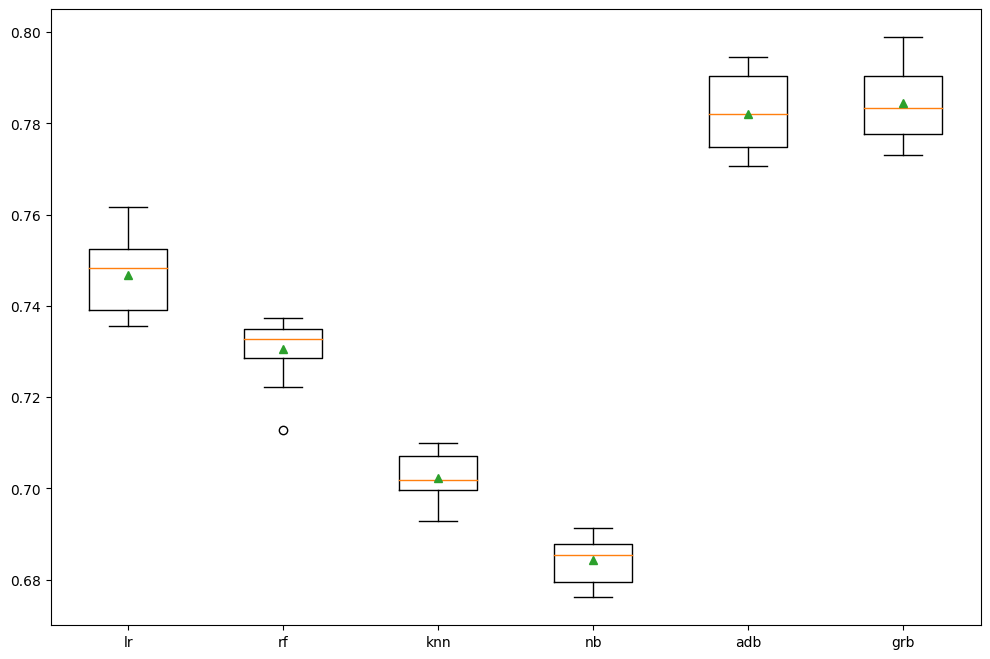

In [23]:
plt.figure(figsize=(12,8))
plt.boxplot(results,labels=names,showmeans=True);

#### Adaboost and Gradientboosting performed best

In [25]:
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

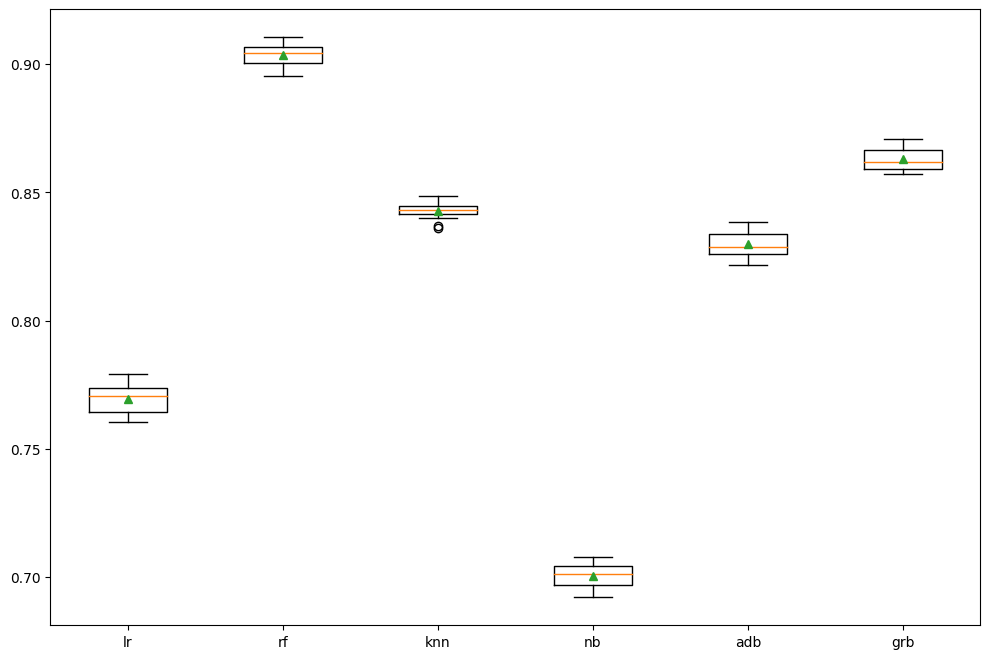

In [26]:
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_res,y_res=resample.fit_resample(X,y)

results=[]
model,names=get_models()

for i in range(len(model)):
    results.append(evaluate(X_res,y_res,model[i]))
    
plt.figure(figsize=(12,8))
plt.boxplot(results,labels=names,showmeans=True);

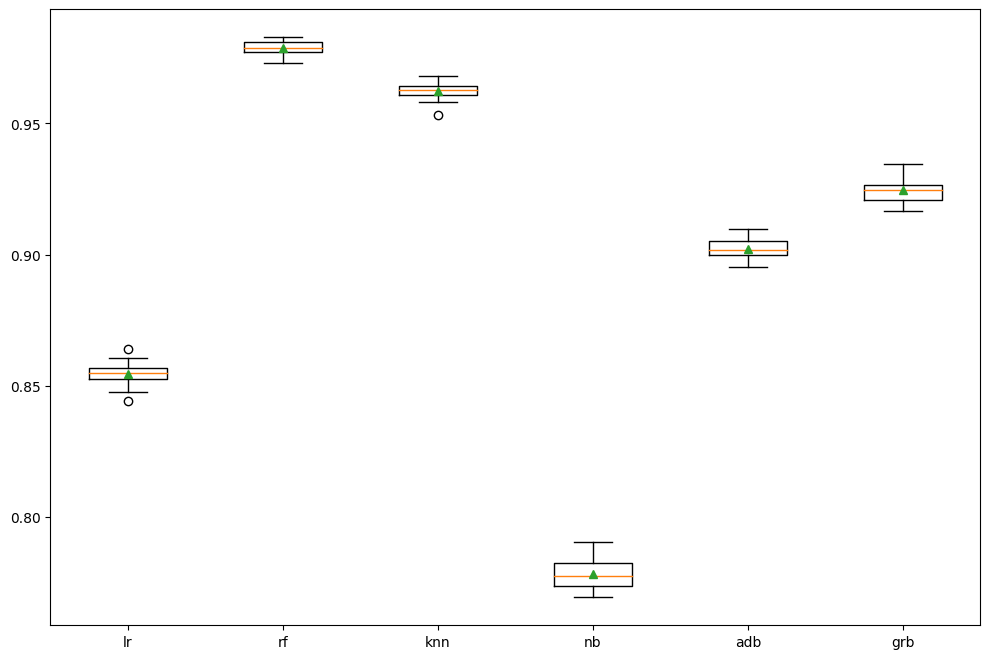

In [27]:
results=[]

resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_res,y_res=resample.fit_resample(X,y)

for i in range(len(model)):
    results.append(evaluate(X_res,y_res,model[i]))
    
plt.figure(figsize=(12,8))
plt.boxplot(results,labels=names,showmeans=True);

##### We have used two types of sampling techniques, they have significantly increased the roc auc score. Out of the two Smote in combination with edited nearest neighbor have performed better than Smote in combination with tomeklinks

In [28]:
resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_res,y_res=resample.fit_resample(X,y)

#### Hyperparameterization

In [29]:
from sklearn.model_selection import GridSearchCV

In [31]:
parameters={'n_estimators':range(150,300,20),
            'max_features':[0.4,0.5,0.6,0.7,0.8]}

In [32]:
model=RandomForestClassifier()
cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

grid=GridSearchCV(model,parameters,scoring='roc_auc',cv=cv,n_jobs=-1)
grid.fit(X_res,y_res)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.4, 0.5, 0.6, 0.7, 0.8],
                         'n_estimators': range(150, 300, 20)},
             scoring='roc_auc')

In [33]:
grid.best_score_

0.974855967826292

In [34]:
params=grid.best_params_

#### Final Model pipeline

In [35]:
inter=Pipeline([('i',SimpleImputer(strategy='most_frequent')),
                ('e',OneHotEncoder()),
                ('fs',SelectKBest(score_func=chi2,k=23))])
              
transformers=[('t',PowerTransformer(),num),
              ('inter',inter,cat)]
    
steps=[('pre',ColumnTransformer(transformers=transformers)),
       ('sampling',SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
       ('model',RandomForestClassifier(**params))]

In [36]:
X_train=train.drop(columns=['enrollee_id','city','target'],axis=1)
y_train=train['target']

X_test=test.drop(columns=['enrollee_id','city'],axis=1)

In [37]:
model=Pipeline(steps=steps)
model.fit(X_train,y_train)

predictions=model.predict(X_test)

In [38]:
submission = pd.DataFrame({'enrollee_id':test['enrollee_id'],'target':predictions})
submission.head(10)

,enrollee_id,target
0,32403,0.0
1,9858,1.0
2,31806,1.0
3,27385,0.0
4,27724,0.0
5,217,1.0
6,21465,1.0
7,27302,1.0
8,12994,1.0
9,16287,1.0


In [43]:
X_test

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...
2124,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
2125,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
2126,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
2127,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


In [41]:
import joblib

In [47]:
# joblib.dump(model,'src/model/model.pkl')

['src/model/model.pkl']